<span style="color: red; font-size: 2em; font-weight: bold;">Example 2: Load - Solar Generator - without Storage unit  </span>


Network Connections:
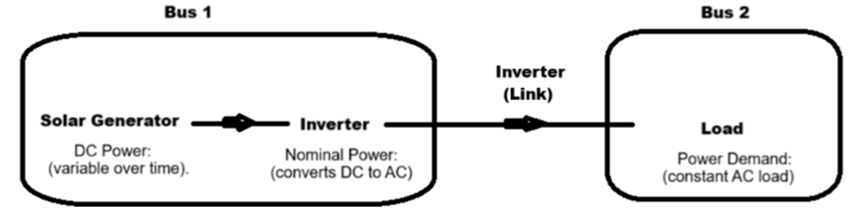

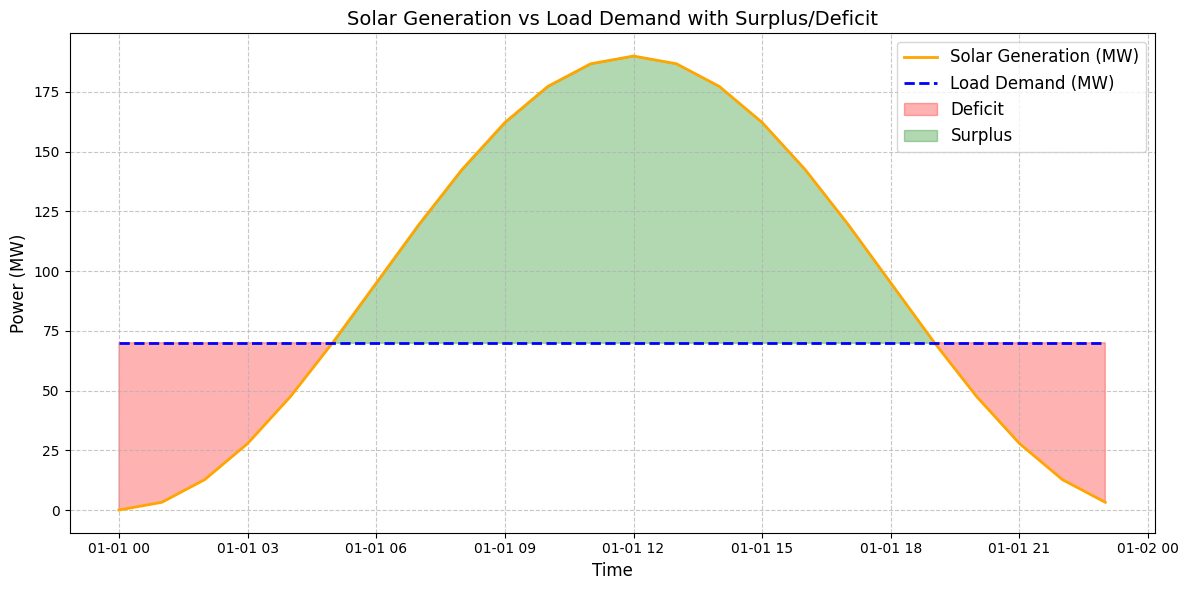

In [1]:
# Example 2 : Load - Solar Generator
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1 Create the network
network = pypsa.Network()

# 2 Add Buses
network.add("Bus", "bus1", carrier="DC")  # DC side (solar generator to inverter)
network.add("Bus", "bus2", carrier="AC")  # AC side (inverter to load)

# 3 Define time steps for the simulation
hours = pd.date_range("2023-01-01 00:00", "2023-01-01 23:00", freq="H")
network.set_snapshots(hours)

# 4 Add Solar Generator at Bus 1 with time dependent power output
# Generate a realistic solar profile. Peaks around midday
solar_profile = pd.Series(0.5 * (1 + np.sin(2 * np.pi * (hours.hour - 6) / 24)), index=network.snapshots)
p_nom_solar = 200  # Nominal power (MW)
network.add("Generator",
            "Solar Generator",
            bus = "bus1",
            p_nom = p_nom_solar, 
            p_max_pu = solar_profile,  
            marginal_cost = 50, 
            carrier="solar")


# 5 Add Inverter (as a link) between Bus 1 (DC) and Bus 2 (AC)
inverter_efficiency = 0.95
network.add("Link", 
            "Inverter",
            bus0 = "bus1",
            bus1 = "bus2",
            p_nom = p_nom_solar,
            efficiency = inverter_efficiency,
            carrier = "inverter")

# 6 Add Load
p_load = 70  # Constant load demand, (MW)
load_demand = pd.Series(p_load, index = network.snapshots)  # Constant across all snapshots
network.add("Load", 
            "Load",
            bus = "bus2", 
            p_set = load_demand)  
 

# Calculate solar generation at each time step (after inverter losses)
solar_generation = solar_profile * p_nom_solar * inverter_efficiency


# Visualization 
# Combined Plot: Solar Generation and Load Demand with Highlighted Surplus/Deficit
plt.figure(figsize=(12, 6))

# Plot Solar Generation
plt.plot(hours, solar_generation, label="Solar Generation (MW)", color="orange", linewidth=2)

# Plot Load Demand
plt.plot(hours, load_demand, label="Load Demand (MW)", color="blue", linestyle="--", linewidth=2)

# Highlight Deficit (When Solar is Insufficient)
plt.fill_between(hours, solar_generation, load_demand, where=(solar_generation < load_demand), 
                 interpolate=True, color="red", alpha=0.3, label="Deficit")

# Highlight Surplus (When Solar is Excessive)
plt.fill_between(hours, solar_generation, load_demand, where=(solar_generation >= load_demand), 
                 interpolate=True, color="green", alpha=0.3, label="Surplus")

# Labels, Legend, and Grid
plt.title("Solar Generation vs Load Demand with Surplus/Deficit", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the Plot
plt.show()


The above standalone solar generator (with a time‐dependent profile) cannot meet a constant load all day (especially at night when solar is zero).
So we should add a 

    storage unit (Example 3 - Load _Solar Generator _Storage Unit)
    or backup (fuel/oil) generator as a slack generator (Example 4 - Load _Solar Generator _Backup Generator) 
    
This ensures feasibility of the optimization. 

This is why we do not run any optimization. Otherways it will through error. 

In this example, the solar generator is not slack (so it only produces according to its profile)

<span style="color: red; font-size: 2em; font-weight: bold;">Step by step code</span>

# Step 1: Setting Up the Environment

## Install PyPSA

In [2]:
#!pip install pypsa

In [3]:
# Import pypsa 
import pypsa

## Additional Libraries
PyPSA may require other libraries for plotting and numerical operations:

In [4]:
# pip install numpy pandas matplotlib networkx

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Creating Your Network:

## Creating the Network

In [6]:
# Create an empty network
network = pypsa.Network()

Network: Represents the electrical network.

## Add buses

In [7]:
# Add 2 buses
network.add("Bus", "bus1", carrier="DC")  # DC side (solar generator to inverter)
network.add("Bus", "bus2", carrier="AC")  # AC side (inverter to load)

network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
bus1,1.0,,0.0,0.0,DC,,1.0,0.0,inf,PQ,
bus2,1.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,


Bus: A bus represents a point in the system where power is injected or consumed. It’s where all electrical components (load, generator) connect.

v_nom: This is the nominal voltage of the bus. For simplicity, we set it to 20 kV.

## Define time steps for the simulation

In [8]:
hours = pd.date_range("2023-01-01 00:00", "2023-01-01 23:00", freq="H")
network.set_snapshots(hours)
hours

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               '2023-01-01 10:00:00', '2023-01-01 11:00:00',
               '2023-01-01 12:00:00', '2023-01-01 13:00:00',
               '2023-01-01 14:00:00', '2023-01-01 15:00:00',
               '2023-01-01 16:00:00', '2023-01-01 17:00:00',
               '2023-01-01 18:00:00', '2023-01-01 19:00:00',
               '2023-01-01 20:00:00', '2023-01-01 21:00:00',
               '2023-01-01 22:00:00', '2023-01-01 23:00:00'],
              dtype='datetime64[ns]', freq='H')

## Add a Generator: Solar Generator

In [9]:
# Generate a realistic solar profile (simple sine curve for daily pattern). Peaks at noon
solar_profile = pd.Series(0.5 * (1 + np.sin(2 * np.pi * (hours.hour - 6) / 24)), index=network.snapshots)
solar_profile

snapshot
2023-01-01 00:00:00    0.000000
2023-01-01 01:00:00    0.017037
2023-01-01 02:00:00    0.066987
2023-01-01 03:00:00    0.146447
2023-01-01 04:00:00    0.250000
2023-01-01 05:00:00    0.370590
2023-01-01 06:00:00    0.500000
2023-01-01 07:00:00    0.629410
2023-01-01 08:00:00    0.750000
2023-01-01 09:00:00    0.853553
2023-01-01 10:00:00    0.933013
2023-01-01 11:00:00    0.982963
2023-01-01 12:00:00    1.000000
2023-01-01 13:00:00    0.982963
2023-01-01 14:00:00    0.933013
2023-01-01 15:00:00    0.853553
2023-01-01 16:00:00    0.750000
2023-01-01 17:00:00    0.629410
2023-01-01 18:00:00    0.500000
2023-01-01 19:00:00    0.370590
2023-01-01 20:00:00    0.250000
2023-01-01 21:00:00    0.146447
2023-01-01 22:00:00    0.066987
2023-01-01 23:00:00    0.017037
Freq: H, dtype: float64

In [10]:
# Add a generator to Bus 1 
p_nom_solar = 200  # Nominal power (MW)
network.add("Generator",
            "Solar Generator",
            bus = "bus1",
            p_nom = p_nom_solar, 
            p_max_pu = solar_profile,  
            marginal_cost = 50, 
            carrier="solar")

# solar_profile, %
#p_max_pu = solar_profile*p_nom

Generator: Represents a generator that supplies power to the grid.

    bus: This defines which bus the generator is connected to, in this case, Bus1. Connected to DC bus
    p_nom: Nominal power capacity (MW)
    p_max_pu=solar_profile,  # Time series for solar output

## Add Inverter (as a link)

In [11]:
# 5 Add Inverter (as a link) between Bus 1 (DC) and Bus 2 (AC)
inverter_efficiency = 0.95
network.add("Link", 
            "Inverter",
            bus0 = "bus1",
            bus1 = "bus2",
            p_nom = p_nom_solar,
            efficiency = inverter_efficiency,
            carrier = "inverter")


            bus0="bus1"  # DC input
            bus1="bus2"  # AC output
            p_nom=100    # Nominal power (MW)
            efficiency=0.95

## Add a Load
A load consumes power from the grid. Let’s add a load to Bus2 that will consume some power.

In [12]:
# Add a load to Bus 2
p_load = 70  # Constant load demand, (MW)
load_demand = pd.Series(p_load, index = network.snapshots)  # Constant across all snapshots
network.add("Load", 
            "Load",
            bus = "bus2", 
            p_set = load_demand)  

Load: Represents a power consumer.

bus: The bus where the load is connected. # Connected to AC bus

p_set: Constant load demand (MW)

## Check the network

In [13]:
# Print the network
print(network)

PyPSA Network
Components:
 - Bus: 2
 - Generator: 1
 - Link: 1
 - Load: 1
Snapshots: 24


C:\Users\faaiz\pypsa_env\lib\site-packages\pypsa\plot.py:230: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.axis(boundaries)


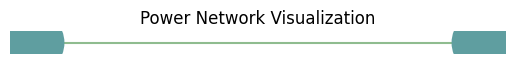

In [14]:
# Visualize the network

import matplotlib.pyplot as plt
network.plot()
plt.title("Power Network Visualization")
plt.show()

# Visualization

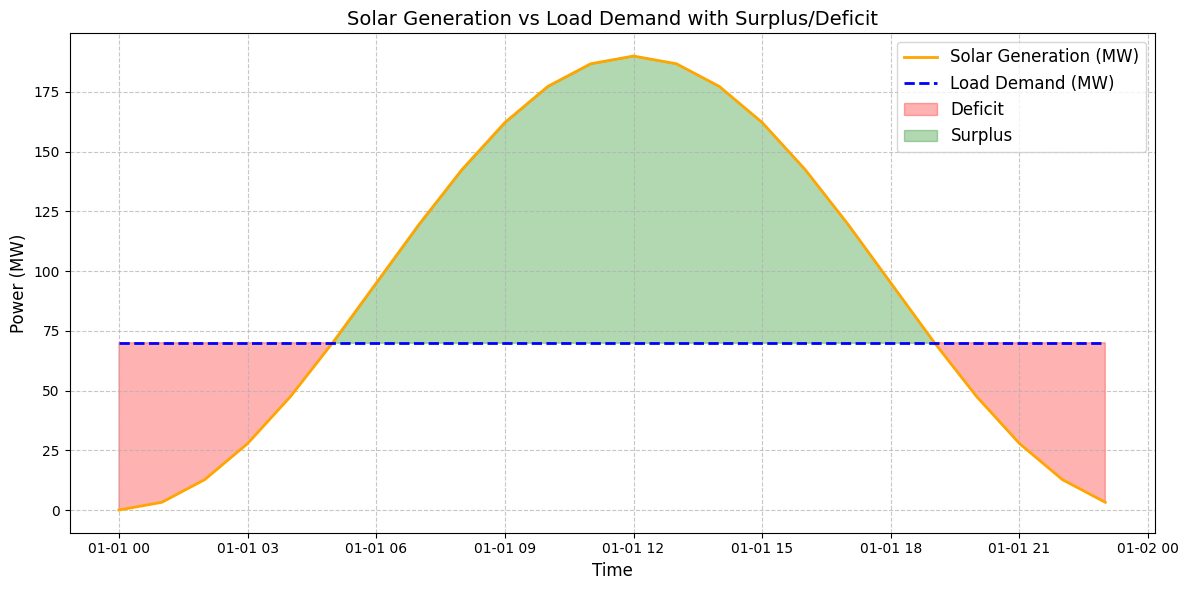

In [15]:
# Calculate solar generation at each time step (after inverter losses)
solar_generation = solar_profile * p_nom_solar * inverter_efficiency


# Visualization 
# Combined Plot: Solar Generation and Load Demand with Highlighted Surplus/Deficit
plt.figure(figsize=(12, 6))

# Plot Solar Generation
plt.plot(hours, solar_generation, label="Solar Generation (MW)", color="orange", linewidth=2)

# Plot Load Demand
plt.plot(hours, load_demand, label="Load Demand (MW)", color="blue", linestyle="--", linewidth=2)

# Highlight Deficit (When Solar is Insufficient)
plt.fill_between(hours, solar_generation, load_demand, where=(solar_generation < load_demand), 
                 interpolate=True, color="red", alpha=0.3, label="Deficit")

# Highlight Surplus (When Solar is Excessive)
plt.fill_between(hours, solar_generation, load_demand, where=(solar_generation >= load_demand), 
                 interpolate=True, color="green", alpha=0.3, label="Surplus")

# Labels, Legend, and Grid
plt.title("Solar Generation vs Load Demand with Surplus/Deficit", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the Plot
plt.show()
